# PBR geometry analysis

In [114]:
import laspy
import numpy as np
import os
import open3d as o3d
from joblib import Parallel, delayed
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as mcolors

In [2]:
def read_las_file(file_path):
    
    # read las file
    las_file = laspy.read(file_path)

    # get the point data
    point_data = las_file.points
    # get the x, y, z coordinates
    x = point_data.x
    y = point_data.y
    z = point_data.z
    # get the intensity values
    semantics = point_data.intensity

    # stock the x, y, z, semantics in a numpy array
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    semantics = np.array(semantics)

    # get color values from las file
    red = point_data.red
    green = point_data.green
    blue = point_data.blue

    colors = np.array([red, green, blue]).T

    # stack the arrays
    points_semantics_source = np.vstack((x, y, z, semantics)).T

    print(points_semantics_source.shape)

    # assert the length of the arrays
    assert len(x) == len(y) == len(z) == len(semantics), "Length of x, y, z, and intensity arrays do not match."

    # print the numbers of points and semantics
    print(f"Number of points: {len(x)}")
    print(f"Number of semantics: {np.unique(semantics).size}")

    return points_semantics_source, colors




In [3]:
def save_points_to_las(points, color, filename):
    # Create a new LAS header and file
    header = laspy.LasHeader(point_format=3, version="1.2")
    las_file = laspy.LasData(header)

    # Set coordinates
    las_file.x = points[:, 0]
    las_file.y = points[:, 1]
    las_file.z = points[:, 2]

    # Handle intensity (semantics)
    semantics = points[:, 3].astype(np.int16)  # Promote to signed int
    max_intensity = semantics[semantics != -1].max()

    if len(semantics[semantics == max_intensity]) < len(semantics)/10:
        semantics[semantics == -1] = max_intensity + 1 
        print(f"Max intensity: {max_intensity + 1}")
    else:
        semantics[semantics == -1] = max_intensity 
        print(f"Max intensity: {max_intensity}")
    las_file.intensity = semantics.astype(np.uint16)  # Cast back to uint16

    

    # Set RGB color
    las_file.red = color[:, 0].astype(np.uint16)
    las_file.green = color[:, 1].astype(np.uint16)
    las_file.blue = color[:, 2].astype(np.uint16)

    # Write the LAS file
    las_file.write(filename)




def cluster_filter(points_semantics, eps=0.5, min_samples=10, n_jobs=8):
    semantics_ids = np.unique(points_semantics[:, 3])

    def process_semantic_group(sem_id):
        # Find global indices for this semantic group
        group_indices = np.where(points_semantics[:, 3] == sem_id)[0]
        group_points = points_semantics[group_indices, :3]

        if len(group_points) < min_samples:
            return group_indices  # All treated as outliers

        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(group_points)
        labels, counts = np.unique(clustering.labels_, return_counts=True)

        # Ignore noise-only cases (no valid clusters)
        if np.all(labels == -1):
            return group_indices

        largest_cluster_label = labels[np.argmax(counts)]
        inliers_local = np.where(clustering.labels_ == largest_cluster_label)[0]
        all_local = np.arange(len(group_indices))
        outliers_local = np.setdiff1d(all_local, inliers_local)

        # Return global indices of outliers
        return group_indices[outliers_local]

    # Parallel loop over semantic IDs
    outlier_indices_all = Parallel(n_jobs=n_jobs)(
        delayed(process_semantic_group)(sid) for sid in semantics_ids
    )

    all_outlier_indices = np.concatenate(outlier_indices_all)
    points_semantics[all_outlier_indices, 3] = -1

    # print the number of outliers
    print(f"Number of outliers from DBSCAN filter: {len(all_outlier_indices)}")

    return points_semantics



def size_filter(points_semantics, min_horizontal_length=0.5, max_horizontal_length=5.0, min_vertical_length=0.5, max_vertical_length=5.0):
    semantics_ids = np.unique(points_semantics[:, 3])

    def process_semantic_group(points_semantics, semantics_id, min_horizontal_length, max_horizontal_length, min_vertical_length, max_vertical_length):
        # Get indices of points with this semantics
        indices = np.where(points_semantics[:, 3] == semantics_id)[0]
        local_points_semantics = points_semantics[indices]
        xyz = local_points_semantics[:, :3]

        # Calculate the bounding box
        min_x, min_y, min_z = np.min(xyz, axis=0)
        max_x, max_y, max_z = np.max(xyz, axis=0)

        # Calculate lengths
        horizontal_length = np.sqrt((max_x - min_x) ** 2 + (max_y - min_y) ** 2)
        vertical_length = max_z - min_z

        # return True if the lengths are within the specified range; otherwise, return False
        if min_horizontal_length <= horizontal_length <= max_horizontal_length and min_vertical_length <= vertical_length <= max_vertical_length:
            return semantics_id, True
        else:
            return semantics_id, False
        
    # Parallel processing
    results = Parallel(n_jobs=8)(
        delayed(process_semantic_group)(points_semantics, sid, min_horizontal_length, max_horizontal_length, min_vertical_length, max_vertical_length)
        for sid in semantics_ids
    )

    # set the semantics to -1 for the points that do not pass the filter
    for semantics_id, keep in results:
        if not keep:
            indices = np.where(points_semantics[:, 3] == semantics_id)[0]
            points_semantics[indices, 3] = -1

    # print the number of semantics_ids that passed the filter
    print(f"Number of semantics_ids that passed the size filter: {len(np.unique(points_semantics[:, 3]))-1}")
    # print the number of semantics_ids that did not pass the filter
    print(f"Number of semantics_ids that did not pass the size filter: {len(semantics_ids) - len(np.unique(points_semantics[:, 3]))+1}")
    return points_semantics


def pca_curvature_filter(points_semantics, curvature_threshold=0.5):
    """
    Filter points based on PCA planarity.
    :param points_semantics: numpy array of shape (N, 4) where N is the number of points
    :param curvature_threshold: float, threshold for curvature; large values indicate more objects will be removed
    """
    semantics_ids = np.unique(points_semantics[:, 3])

    def process_semantic_group(points_semantics, semantics_id, ratio):
        # Get indices of points with this semantics
        indices = np.where(points_semantics[:, 3] == semantics_id)[0]
        local_points_semantics = points_semantics[indices]
        xyz = local_points_semantics[:, :3]

        # Center the points
        xyz = xyz - np.mean(xyz, axis=0)

        # Perform PCA
        pca = PCA(n_components=3)
        pca.fit(xyz)

        eigenvalues = pca.explained_variance_  # λ₁, λ₂, λ₃

        # Sort eigenvalues from largest to smallest
        eigenvalues = np.sort(eigenvalues)[::-1]
        λ1, λ2, λ3 = eigenvalues


        # Avoid divide by zero
        if λ1 == 0:
            return 0.0  # when all points are the same

        curvature = λ3 / (λ1 + λ2 + λ3)  
        
        if curvature > ratio:   # less flat
            return semantics_id, True
        else:  # more flat
            return semantics_id, False
        
    # Parallel processing
    results = Parallel(n_jobs=8)(
        delayed(process_semantic_group)(points_semantics, sid, curvature_threshold)
        for sid in semantics_ids
    )
    # set the semantics to -1 for the points that do not pass the filter
    for semantics_id, keep in results:
        if not keep:
            indices = np.where(points_semantics[:, 3] == semantics_id)[0]
            points_semantics[indices, 3] = -1
    # print the number of semantics_ids that passed the filter
    print(f"Number of semantics_ids that passed the PCA filter: {len(np.unique(points_semantics[:, 3]))-1}")
    # print the number of semantics_ids that did not pass the filter
    print(f"Number of semantics_ids that did not pass the PCA filter: {len(semantics_ids) - len(np.unique(points_semantics[:, 3]))+1}")
    return points_semantics

def density_filter(points_semantics, semantics_id, radius=0.1, density_threshold=0.5):
    semantics_ids = np.unique(points_semantics[:, 3])
    
    def compute_point_density(points_semantics, semantics_id, radius=0.1, density_threshold=0.5):
        # Get indices of points with this semantics
        indices = np.where(points_semantics[:, 3] == semantics_id)[0]
        local_points_semantics = points_semantics[indices]
        xyz = local_points_semantics[:, :3]
        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(xyz)
        # Compute point density
        pcd_tree = o3d.geometry.KDTreeFlann(pcd)
        densities = []
        points = np.asarray(pcd.points)
        
        for i in range(len(points)):
            [k, idx, _] = pcd_tree.search_radius_vector_3d(pcd.points[i], radius)
            densities.append(k)

        density = np.mean(densities)
                
        if density >= density_threshold:
            return semantics_id, True
        else:
            return semantics_id, False
        
    # Parallel processing
    results = Parallel(n_jobs=8)(
        delayed(compute_point_density)(points_semantics, sid, radius, density_threshold)
        for sid in semantics_ids
    )
    # set the semantics to -1 for the points that do not pass the filter
    for semantics_id, keep in results:
        if not keep:
            indices = np.where(points_semantics[:, 3] == semantics_id)[0]
            points_semantics[indices, 3] = -1
    # print the number of semantics_ids that passed the filter
    print(f"Number of semantics_ids that passed the density filter: {len(np.unique(points_semantics[:, 3]))-1}")
    # print the number of semantics_ids that did not pass the filter
    print(f"Number of semantics_ids that did not pass the density filter: {len(semantics_ids) - len(np.unique(points_semantics[:, 3]))+1}")
    return points_semantics


def hwr_filter(points_semantics, hwr_threshold=10.0):
    semantics_ids = np.unique(points_semantics[:, 3])
    
    def compute_hwr(points_semantics, semantics_id):
        # Get indices of points with this semantics
        indices = np.where(points_semantics[:, 3] == semantics_id)[0]
        local_points_semantics = points_semantics[indices]
        xyz = local_points_semantics[:, :3]

        # center the points
        xyz = xyz - np.mean(xyz, axis=0)

        pca = PCA(n_components=3)
        pca.fit(xyz)

        # Get the eigenvalues
        eigenvalues = pca.explained_variance_
        # Get the eigenvectors
        eigenvectors = pca.components_

        # find the eigenvector aligned with the z-axis
        z_axis = np.array([0, 0, 1])
        # find the angle between the eigenvector and the z-axis
        cosines = np.abs(np.dot(eigenvectors, z_axis))
        index = np.argmax(cosines)
        # find the index of the eigenvalue associated with width, which is the smaller eigenvalue in the remaining eigenvalues
        # Remaining two axes
        other_indices = [0, 1, 2]
        other_indices.remove(index)

        # Compare the two remaining eigenvalues to get the width direction
        if eigenvalues[other_indices[0]] < eigenvalues[other_indices[1]]:
            width_index = other_indices[0]
        else:
            width_index = other_indices[1]

        length_index = other_indices[0] if width_index == other_indices[1] else other_indices[1]

        """
        print("Height: ", eigenvectors[index], eigenvalues[index])
        print("Width: ", eigenvectors[width_index], eigenvalues[width_index])
        print("Length: ", eigenvectors[length_index], eigenvalues[length_index])
        print('.')
        """

        # transform the points to the PCA space
        pca_points = pca.transform(xyz)

        pca_z = pca_points[:, index]
        pca_width = pca_points[:, width_index]

        min_z, min_width = np.min(pca_z), np.min(pca_width)
        max_z, max_width = np.max(pca_z), np.max(pca_width)

        height = max_z - min_z
        width = max_width - min_width
        hwr = height / width
        return semantics_id, hwr

    
    # Parallel processing
    results = Parallel(n_jobs=1)(
        delayed(compute_hwr)(points_semantics, sid)
        for sid in semantics_ids if sid != -1
    )
    
    # set the background_id to the largest semantics_id if the number of the points in the largest semantics_id is more than 10% of the points
    # get the largest semantics_id
    largest_semantics_id = np.max(points_semantics[:, 3])
    # get the number of points in the largest semantics_id
    largest_semantics_id_count = np.sum(points_semantics[:, 3] == largest_semantics_id)
    # get the number of points
    total_points_count = points_semantics.shape[0]
    # set the background_id to the largest semantics_id if the number of points in the largest semantics_id is more than 10% of the points
    if largest_semantics_id_count > total_points_count / 10:
        background_id = largest_semantics_id
    else:
        # set the background_id to -1
        background_id = -1

    # semantics_hwr dictionary
    semantics_hwr = {}
    for semantics_id, hwr in results:
        if hwr > hwr_threshold:
            indices = np.where(points_semantics[:, 3] == semantics_id)[0]
            points_semantics[indices, 3] = background_id
        else:
            semantics_hwr[semantics_id] = hwr

    # print the number of semantics_ids that passed the filter
    print(f"Number of semantics_ids that passed the HWR filter: {len(np.unique(points_semantics[:, 3]))-1}")
    # print the number of semantics_ids that did not pass the filter
    print(f"Number of semantics_ids that did not pass the HWR filter: {len(semantics_ids) - len(np.unique(points_semantics[:, 3]))+1}")
    return points_semantics, semantics_hwr


In [181]:
# points_semantics_source, colors = read_las_file("data/centennial_bluff_mission_a_0.las")
# points_semantics = points_semantics_source.copy()
# points_semantics = cluster_filter(points_semantics, eps=0.3, min_samples=10, n_jobs=8)
# points_semantics = size_filter(points_semantics, min_horizontal_length=0.3, max_horizontal_length=4.0, min_vertical_length=0.3, max_vertical_length=4.0)
# save_points_to_las(points_semantics, colors, "data/centennial_bluff_mission_a_0_size_filtered.las")
# print("number of unique semantics ids: ", len(np.unique(points_semantics[:, 3]))-1)

# points_semantics_source, colors = read_las_file("data/centennial_bluff_mission_a_0_size_filtered.las")
# points_semantics = points_semantics_source.copy()
# points_semantics = pca_curvature_filter(points_semantics, curvature_threshold=0.15)
# save_points_to_las(points_semantics, colors, "data/centennial_bluff_mission_a_0_pca_filtered.las")
# print("number of unique semantics ids: ", len(np.unique(points_semantics[:, 3]))-1)


# points_semantics_source, colors = read_las_file("data/centennial_bluff_mission_a_0_pca_filtered.las")
# points_semantics = points_semantics_source.copy()
# points_semantics = density_filter(points_semantics, semantics_id=1, radius=0.1, density_threshold=4.6)
# save_points_to_las(points_semantics, colors, "data/centennial_bluff_mission_a_0_density_filtered.las")
# print("number of unique semantics ids: ", len(np.unique(points_semantics[:, 3]))-1)

points_semantics_source, colors = read_las_file("data/centennial_bluff_mission_a_0_density_filtered.las")
points_semantics = points_semantics_source.copy()
points_semantics, semantics_hwr = hwr_filter(points_semantics, hwr_threshold=2.2)
save_points_to_las(points_semantics, colors, "data/centennial_bluff_mission_a_0_hwr_filtered.las")
print("number of unique semantics ids: ", len(np.unique(points_semantics[:, 3]))-1)



(4648369, 4)
Number of points: 4648369
Number of semantics: 44
Number of semantics_ids that passed the HWR filter: 42
Number of semantics_ids that did not pass the HWR filter: 2
Max intensity: 6519
number of unique semantics ids:  42


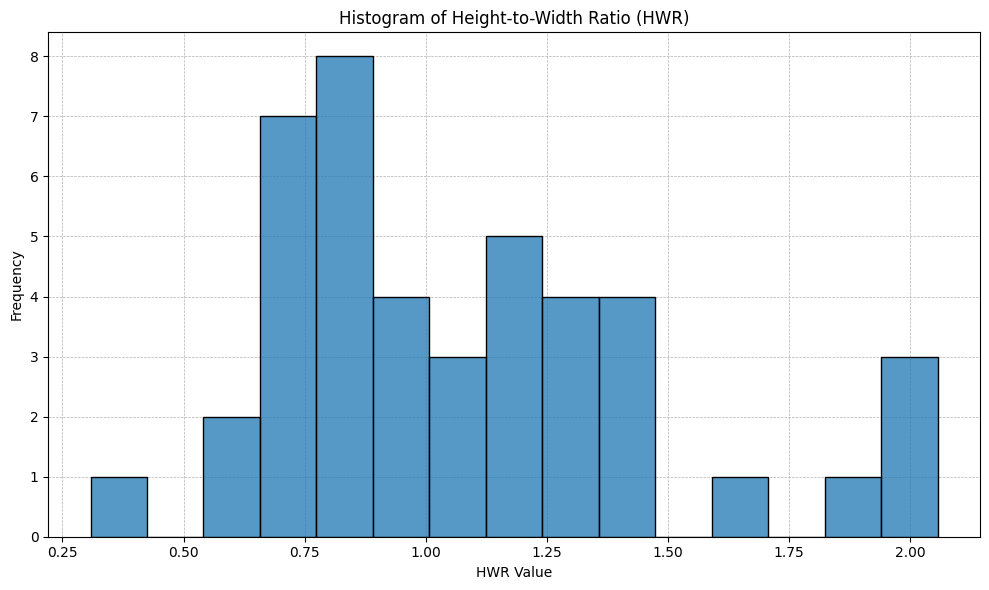

In [182]:
hwr_list = list(semantics_hwr.values())

plt.figure(figsize=(10, 6))
ax = sns.histplot(hwr_list, bins=15, legend=False)

# Grid behind the bars
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', linewidth=0.5)

# Updated title and labels
ax.set_title('Histogram of Height-to-Width Ratio (HWR)')
ax.set_xlabel('HWR Value')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig("data/hwr_histogram.png", dpi=300)
plt.show()

In [183]:
# Sort remaining semantic IDs by their HWR values (ascending order)
sorted_semantics = sorted(semantics_hwr.items(), key=lambda x: x[1])  # (sem_id, hwr)
old_to_new_id = {old_id: new_id for new_id, (old_id, _) in enumerate(sorted_semantics)}

# Apply the new semantic ID mapping
for old_id, new_id in old_to_new_id.items():
    indices = np.where(points_semantics[:, 3] == old_id)[0]
    points_semantics[indices, 3] = new_id

print(f"Assigned new semantic IDs from 0 to {len(old_to_new_id)-1}")

save_points_to_las(points_semantics, colors, "data/centennial_bluff_mission_a_0_sorted.las")

Assigned new semantic IDs from 0 to 42
Max intensity: 43


In [ ]:
def compute_point_density(points_semantics, semantics_id, radius=0.1, density_threshold=0.5):
    # Get indices of points with this semantics
    indices = np.where(points_semantics[:, 3] == semantics_id)[0]
    local_points_semantics = points_semantics[indices]
    xyz = local_points_semantics[:, :3]
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    # Compute point density
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    densities = []
    points = np.asarray(pcd.points)
    
    for i in range(len(points)):
        [k, idx, _] = pcd_tree.search_radius_vector_3d(pcd.points[i], radius)
        densities.append(k)

    density = np.mean(densities)

    print(f"Density: {density}")
            
    if density >= density_threshold:
        return semantics_id, True
    else:
        return semantics_id, False

In [73]:
compute_point_density(points_semantics, semantics_id=5932, radius=0.1, density_threshold=4.5)

Density: 5.005702066999287


(5932, True)

In [134]:
def draw_transparent_circle(image, center, radius, color, alpha=0.5):
    """
    Draw a transparent circle on the image.
    
    Parameters:
    - image: np.ndarray, shape (H, W, 3)
    - center: tuple (x, y)
    - radius: int
    - color: tuple (B, G, R)
    - alpha: float between 0 (transparent) and 1 (opaque)
    """
    overlay = image.copy()
    cv2.circle(overlay, center, radius, color, -1)
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)


def voxel_orthomosaic(points_semantics, colors, semantics_hwr, resolution=0.01):
    xyz = points_semantics[:, :3]
    semantics = points_semantics[:, 3].astype(int)
    semantics_ids = np.unique(semantics)

    # Convert color from uint16 to float [0, 1]
    colors_float = (colors / 65535).astype(np.float32)

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd.colors = o3d.utility.Vector3dVector(colors_float)

    # Create orthomosaic canvas
    x_min, x_max = np.min(xyz[:, 0]), np.max(xyz[:, 0])
    y_min, y_max = np.min(xyz[:, 1]), np.max(xyz[:, 1])
    width_size = int(np.ceil((x_max - x_min) / resolution))
    height_size = int(np.ceil((y_max - y_min) / resolution))

    ortho = np.full((height_size, width_size, 3), 255, dtype=np.uint8)  # white background

    # Paint orthomosaic with point colors
    for i in range(len(pcd.points)):
        point = np.asarray(pcd.points[i])
        color = np.asarray(pcd.colors[i]) * 255
        x_pixel = int((point[0] - x_min) / resolution)
        y_pixel = int((point[1] - y_min) / resolution)
        if 0 <= x_pixel < width_size and 0 <= y_pixel < height_size:
            ortho[y_pixel, x_pixel] = color.astype(np.uint8)

    # Prepare color map for semantics based on HWR
    hwr_array = np.array(list(semantics_hwr.values()))
    norm = mcolors.Normalize(vmin=hwr_array.min(), vmax=hwr_array.max())
    cmap = cm.get_cmap('jet')

    # Draw circles at cluster centers with HWR-based color
    for semantics_id in semantics_ids:
        if semantics_id not in semantics_hwr:
            continue
        indices = np.where(semantics == semantics_id)[0]
        cluster_points = np.asarray(pcd.points)[indices]
        center = np.mean(cluster_points, axis=0)
        hwr = semantics_hwr[semantics_id]
        rgba = cmap(norm(hwr))
        color = tuple(int(255 * c) for c in rgba[:3])

        x_pixel = int((center[0] - x_min) / resolution)
        y_pixel = int((center[1] - y_min) / resolution)

        if 0 <= x_pixel < width_size and 0 <= y_pixel < height_size:
            #cv2.circle(ortho, (x_pixel, y_pixel), 20, color, -1)
            draw_transparent_circle(ortho, (x_pixel, y_pixel), 20, color, alpha=0.7)

    print(f"Orthomosaic size: Width = {width_size}, Height = {height_size}")
    return ortho, x_min, y_min


In [135]:
ortho_image, x_min, y_min = voxel_orthomosaic(points_semantics, colors, semantics_hwr, resolution=0.05)


/var/folders/hd/v79cys4d00n4d9rywlwq4ph40000gn/T/ipykernel_81992/3118887274.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


Orthomosaic size: Width = 3949, Height = 2616


/var/folders/hd/v79cys4d00n4d9rywlwq4ph40000gn/T/ipykernel_81992/1264980563.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


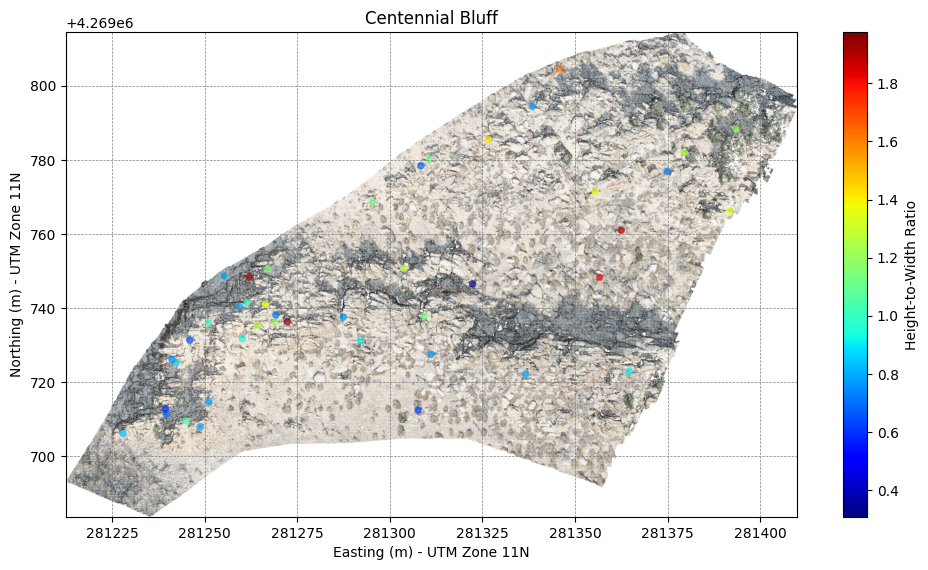

In [ ]:
def plot_orthomap(ortho_image, x_min, y_min, resolution, semantics_hwr):
    H, W, _ = ortho_image.shape

    # Compute extent
    x_max = x_min + W * resolution
    y_max = y_min + H * resolution
    extent = [x_min, x_max, y_min, y_max]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Show ortho image
    im = ax.imshow(ortho_image, extent=extent, origin='lower', zorder=1)

    # Set axis labels and title
    ax.set_xlabel("Easting (m) - UTM Zone 11N")
    ax.set_ylabel("Northing (m) - UTM Zone 11N")
    ax.set_title("Centennial Bluff")

    # Grid settings
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', zorder=0)
    ax.set_aspect('equal')

    # Set up colorbar for HWR values
    hwr_values = list(semantics_hwr.values())
    vmin = min(hwr_values)
    vmax = max(hwr_values)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap('jet')

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5)
    cbar.set_label("Height-to-Width Ratio")

    plt.tight_layout()
    # save 
    plt.savefig("data/centennial_bluff_ortho_map.png", dpi=300)
    plt.show()


plot_orthomap(ortho_image, x_min, y_min, resolution=0.05, semantics_hwr=semantics_hwr)

In [176]:
def impose_color_to_semantics_points(points_semantics, colors, semantics_hwr):
    # Create a color map
    hwr_array = np.array(list(semantics_hwr.values()))
    norm = mcolors.Normalize(vmin=hwr_array.min(), vmax=hwr_array.max())
    cmap = cm.get_cmap('jet')

    # Create a new color array
    color_array = colors.copy()

    for semantics_id, hwr in semantics_hwr.items():
        indices = np.where(points_semantics[:, 3] == semantics_id)[0]

        # if the indices number is greater than 10% of the points, set the color to the orginal color
        if len(indices) < len(points_semantics) / 10:
            # Get the color from the colormap
            rgba = cmap(norm(hwr))
            color = tuple(int(255 * 255 * c) for c in rgba[:3])
            color_array[indices] = color

    return color_array


new_colors = impose_color_to_semantics_points(points_semantics, colors, semantics_hwr)
save_points_to_las(points_semantics, new_colors, "data/centennial_bluff_mission_a_0_sorted_color.las")

/var/folders/hd/v79cys4d00n4d9rywlwq4ph40000gn/T/ipykernel_81992/926329926.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


Max intensity: 6519


In [177]:
semantics_hwr

{np.float64(873.0): np.float64(1.9767121476210872),
 np.float64(1208.0): np.float64(0.8135520103717715),
 np.float64(1216.0): np.float64(0.7558043781313792),
 np.float64(1389.0): np.float64(0.7301165427642232),
 np.float64(1634.0): np.float64(0.8035751826105325),
 np.float64(2153.0): np.float64(0.8193172764320754),
 np.float64(2200.0): np.float64(1.2016136672529896),
 np.float64(2302.0): np.float64(0.8130825177515901),
 np.float64(2439.0): np.float64(1.4694364339345625),
 np.float64(2621.0): np.float64(1.9330190269809255),
 np.float64(2990.0): np.float64(0.9381970519928561),
 np.float64(3236.0): np.float64(0.7949048682321201),
 np.float64(3239.0): np.float64(1.1720314394005655),
 np.float64(3290.0): np.float64(1.3009693595787866),
 np.float64(3615.0): np.float64(0.7184035823860346),
 np.float64(3648.0): np.float64(1.385622139712938),
 np.float64(3663.0): np.float64(1.3061556188631522),
 np.float64(3678.0): np.float64(1.0467931786156406),
 np.float64(3998.0): np.float64(0.64049459872932